<a href="https://colab.research.google.com/github/DavisonDWilson/train-delay-clustering/blob/main/Cluster_analysis_of_train_delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from datetime import datetime

In [ ]:
house_data = files.upload()
df_raw = pd.read_csv("2018_04.csv")

Saving 2018_04.csv to 2018_04.csv


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256267 entries, 0 to 256266
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            256267 non-null  object 
 1   train_id        256267 non-null  object 
 2   stop_sequence   242793 non-null  float64
 3   from            256267 non-null  object 
 4   from_id         256267 non-null  int64  
 5   to              256267 non-null  object 
 6   to_id           256267 non-null  int64  
 7   scheduled_time  242793 non-null  object 
 8   actual_time     256267 non-null  object 
 9   delay_minutes   242793 non-null  float64
 10  status          256267 non-null  object 
 11  line            256267 non-null  object 
 12  type            256267 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 25.4+ MB


In [ ]:
df_raw.isnull().sum()*100/df_raw.isnull().count()#check for nulls

date              0.000000
train_id          0.000000
stop_sequence     5.257798
from              0.000000
from_id           0.000000
to                0.000000
to_id             0.000000
scheduled_time    5.257798
actual_time       0.000000
delay_minutes     5.257798
status            0.000000
line              0.000000
type              0.000000
dtype: float64

since there are plenty of samples and so few null rows, they will be dropped.

In [ ]:
df_raw = df_raw.dropna()

In [ ]:
df = pd.DataFrame()
df_raw['date_formatted'] = pd.to_datetime(df_raw['date'])#this is just a placeholder for further analysis
#The days of the week, month, and year are separated to see if there are patterns at each time scale
df['day_of_week'] = df_raw['date_formatted'].dt.dayofweek
df['day_of_month'] = df_raw['date_formatted'].dt.day
df['day_of_year'] = df_raw['date_formatted'].dt.dayofyear
df['id'] = df_raw['train_id'].astype(int)
df['stop_num']=df_raw['stop_sequence']
#for each station there is a northbound and a southbound track. As northbound and southbound trains will face different types of delays and head to different 
#stations, they will be treated differently. To do so, the ids of the 'from' and 'to' stations are combined. 100,000 is multiplied to the 'from' id
#to make the digits for each id in a separate position in the number so each combined 'from-to' id is unique. No station ids are more than five digits long.
df['station_id'] = df_raw['from_id']*100000 + df_raw['to_id']
df_raw['scheduled_departure_datetime']=pd.to_datetime(df_raw['scheduled_time'])#this is just a placeholder for further analysis
#since the scheduled departure date is always the same as the 'date' feature, only the time of day is saved from the scheduled departure date-time.
#The time of day is converted into minutes after midnight to make the distance measurements used by the cluster algorithms more meaningful.
df['scheduled_departure'] = ((df_raw['scheduled_departure_datetime'] - df_raw['scheduled_departure_datetime'].dt.normalize()) / pd.Timedelta('1 minute')).astype(int)
df['delay_minutes'] = df_raw['delay_minutes']
df['status'] = df_raw['status'].astype('category').cat.codes
df['line'] = df_raw['line'].astype('category').cat.codes
df['type'] = df_raw['type'].astype('category').cat.codes

In [ ]:
df.head()

,day_of_week,day_of_year,day_of_month,id,stop_num,station_id,scheduled_departure,delay_minutes,status,line,type
0,6,91,1,7837,1.0,10500105,674,0.166667,1,7,0
1,6,91,1,7837,2.0,10538187,683,3.083333,1,7,0
2,6,91,1,7837,3.0,3818700107,692,4.116667,1,7,0
3,6,91,1,7837,4.0,10737953,697,3.133333,1,7,0
4,6,91,1,7837,5.0,3795300041,702,4.066667,1,7,0


In [ ]:
df.describe()

,day_of_week,day_of_year,day_of_month,id,stop_num,station_id,scheduled_departure,delay_minutes,status,line,type
count,242793.000000,242793.000000,242793.000000,242793.000000,242793.000000,2.427930e+05,242793.000000,242793.000000,242793.000000,242793.000000,242793.0
mean,2.572751,105.353206,15.353206,3360.929112,8.002035,4.271432e+08,823.560029,3.520321,1.074463,5.129332,0.0
std,1.936046,8.578634,8.578634,2353.964576,5.086811,1.185171e+09,346.304712,6.084378,0.302253,2.607443,0.0
min,0.000000,91.000000,1.000000,41.000000,1.000000,1.000010e+05,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,98.000000,8.000000,1148.000000,4.000000,5.800116e+06,518.000000,1.016667,1.000000,3.000000,0.0
50%,2.000000,106.000000,16.000000,3326.000000,7.000000,1.033291e+07,855.000000,2.133333,1.000000,5.000000,0.0
75%,4.000000,113.000000,23.000000,5438.000000,11.000000,1.360009e+07,1117.000000,4.133333,1.000000,7.000000,0.0
max,6.000000,120.000000,30.000000,9653.000000,26.000000,4.359900e+09,1439.000000,108.116667,2.000000,10.000000,0.0


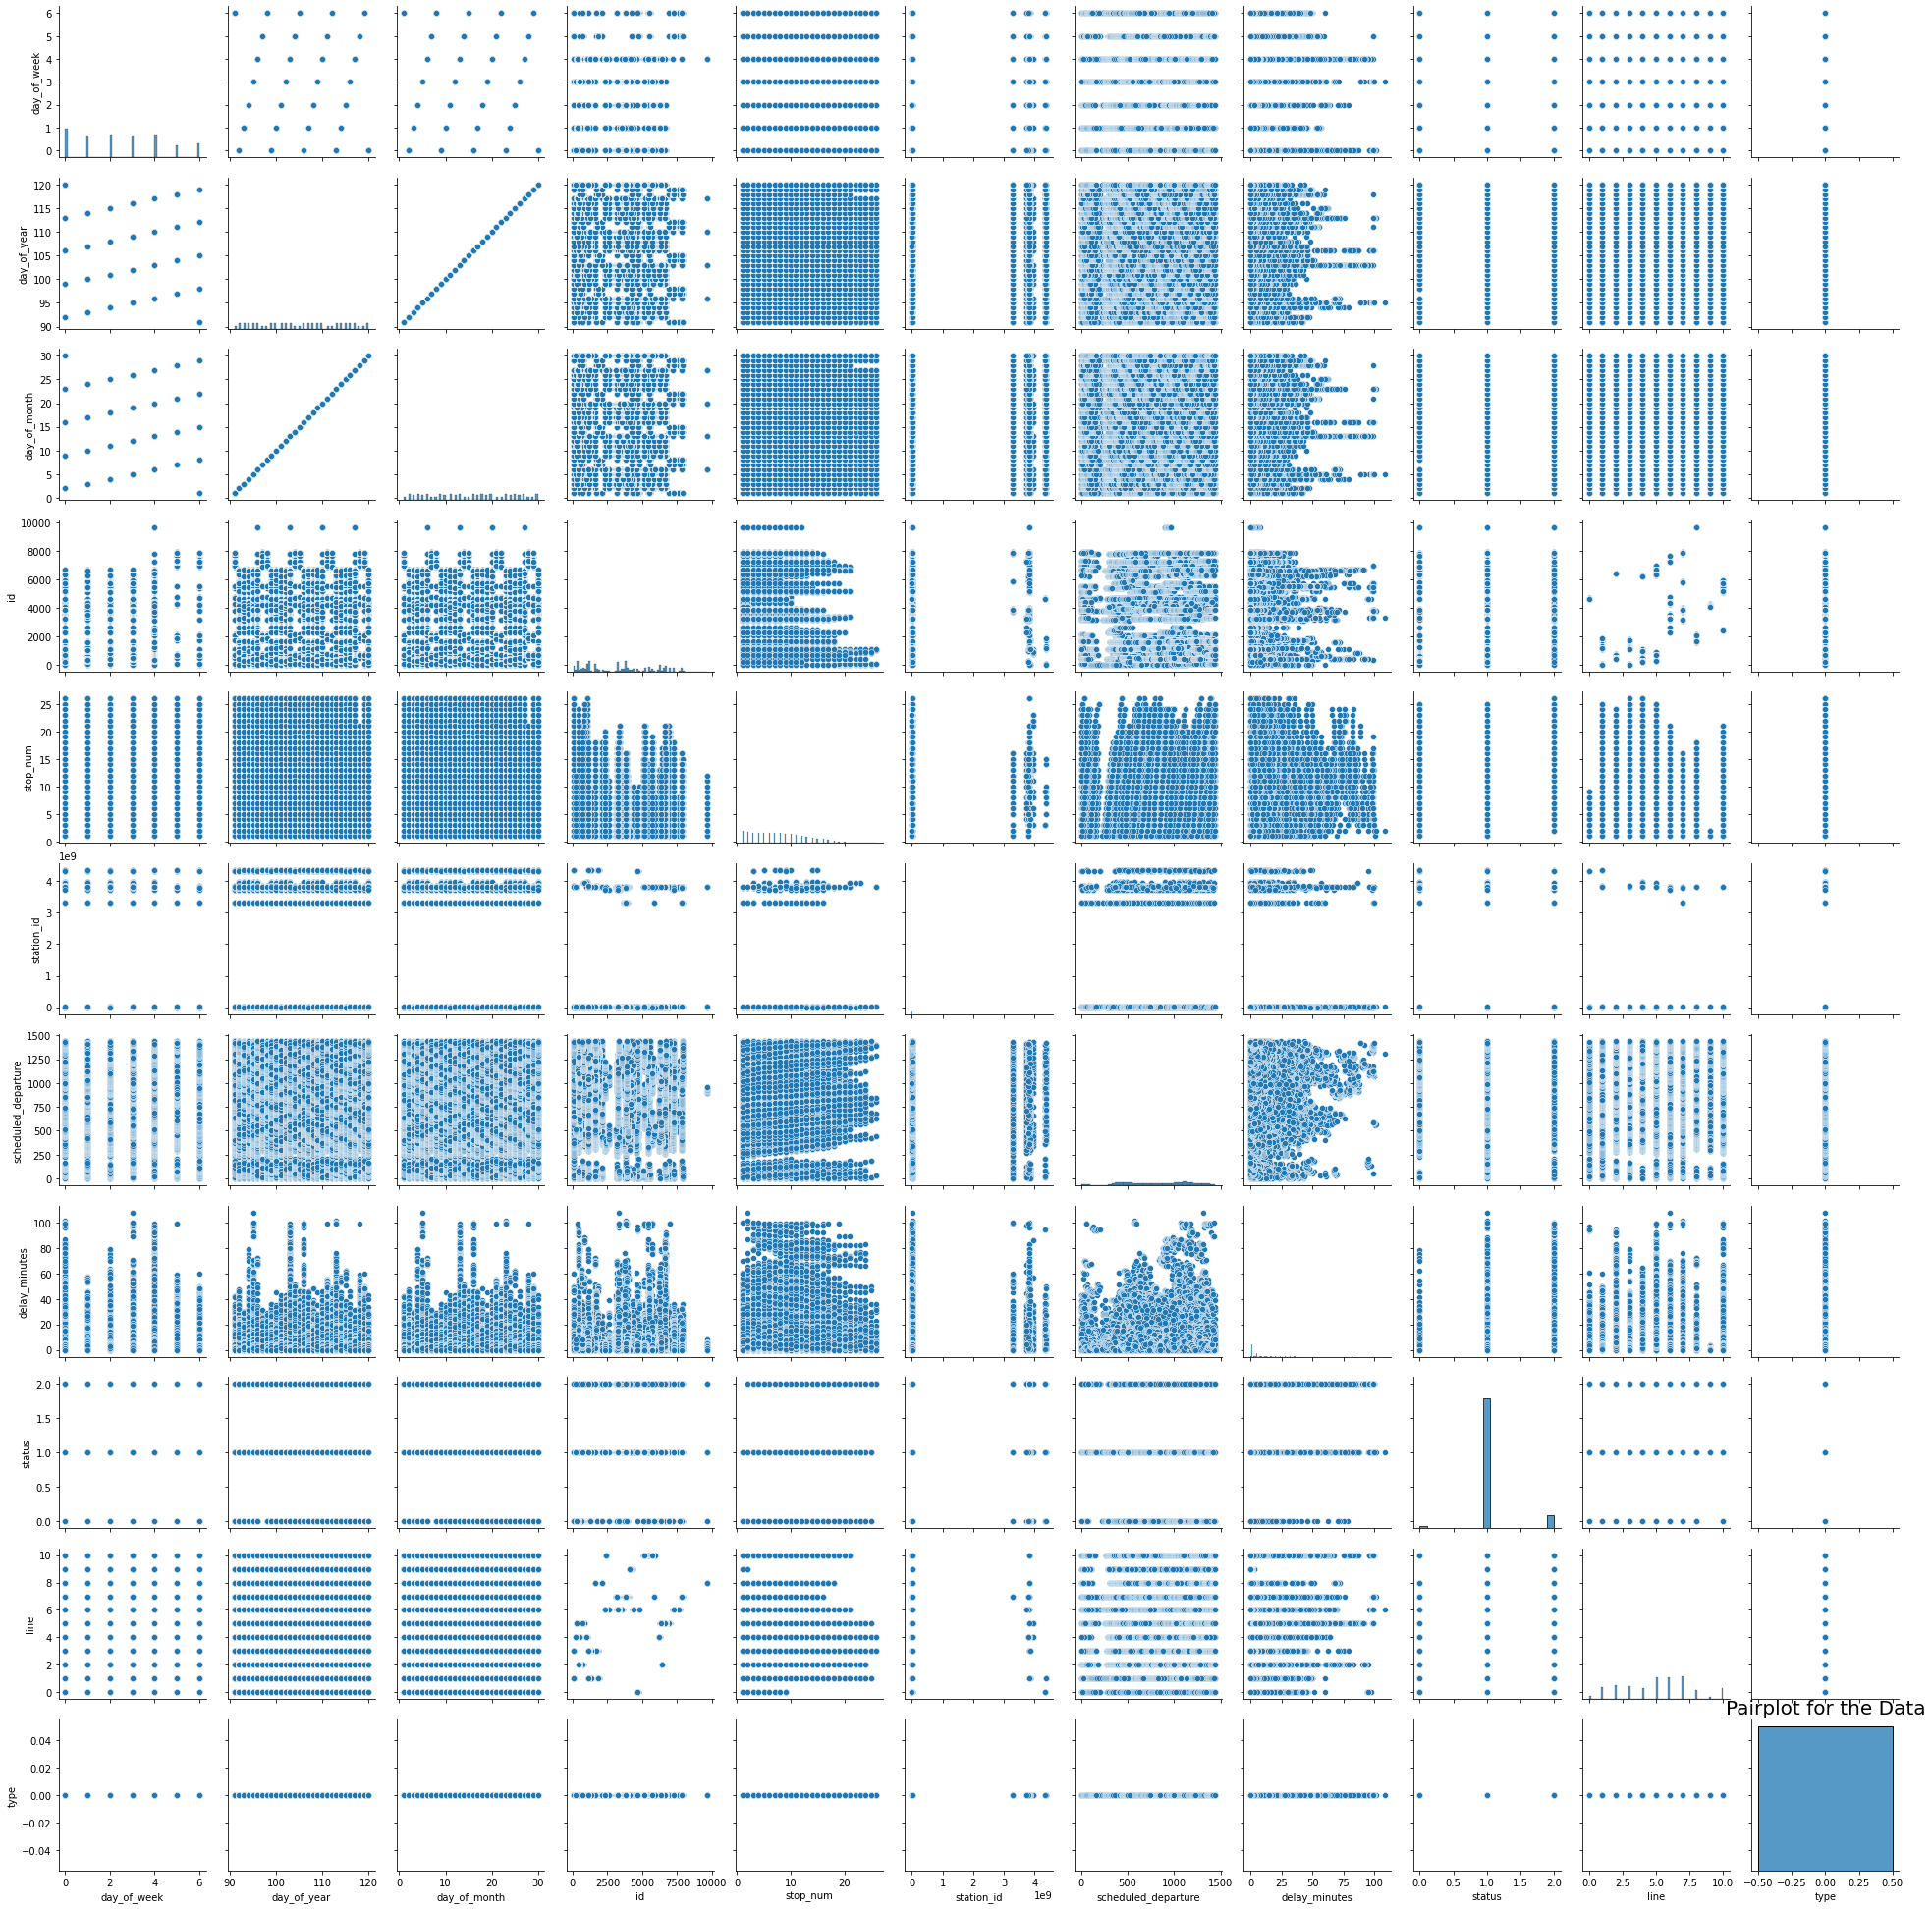

In [ ]:
sns.pairplot(df)
plt.title('Pairplot for the Data', fontsize = 20)
plt.show()

There aren't many clear patterns in the pairwise data. However, some conclusions can be drawn. The 'type' feature only has one value. It won't be very useful so it will be dropped. Also, unsurprisingly the day of the month and day of the year are correlated. This makes sense as only one month's worth of data was included. Those two features must be perfectly correlated. The day of the year will be dropped. Also, line and id seem fairly correlated.

In [ ]:
df=df.drop('type', axis=1)
df=df.drop('day_of_year', axis=1)

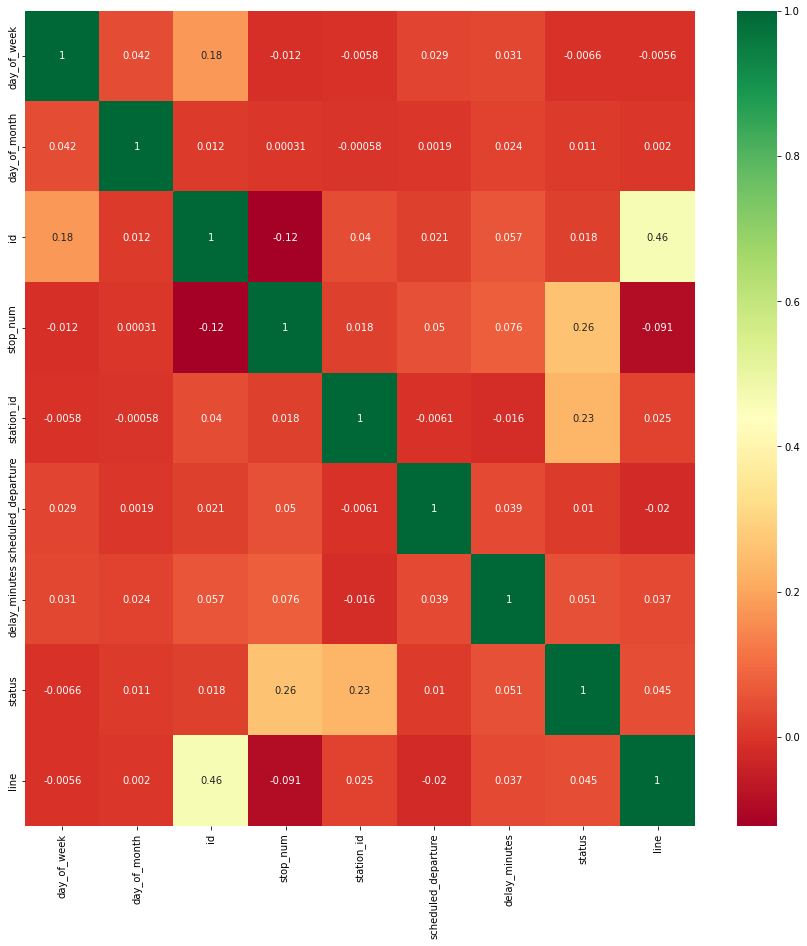

In [ ]:
corrmat = df.loc[:,['day_of_week', 'day_of_month', 'id', 'stop_num', 'station_id', 'scheduled_departure', 'delay_minutes', 'status', 'line']].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

The heat map confirms the conclusions about correlation from the pairwise comparison. Only the 'line' and 'id' features are heavily correlated.

In [ ]:
min_max_scaler = MinMaxScaler()
df_scaled = pd.DataFrame(min_max_scaler.fit_transform(df.values))

In [ ]:
# determine how many components to keep
pca = PCA()
pca_components_all = pca.fit_transform(df_scaled)
pca.explained_variance_ratio_

array([0.21498447, 0.17550043, 0.16661399, 0.14510005, 0.1121778 ,
       0.08259339, 0.06170116, 0.03531681, 0.00601189])

The first five components explain 84% of the variance. No more than five components will be considered when doing dimensional reduction using PCA.

In [ ]:
def plot_k_clusters(cluster_labels, raw_data, axis_1, axis_2): #only works up to 9 clusters
  colors = ['#6767ED', '#E84444', '#67ED7A','#BA67ED','#67EDD3','#E7ED67','#ED67BD', '#ED6767', '#67AAED']
  for k_num in np.unique(cluster_labels):
    plt.scatter(raw_data[cluster_labels == k_num, axis_1], raw_data[cluster_labels == k_num, axis_2], s = 100, c = colors[k_num])
  #plt.xlabel('Annual Income')
  #plt.ylabel('Spending Score')
  #plt.grid()
  #plt.show()

Below a variety of different numbers of components and clusters are plotted to compare the effects of these parameters.

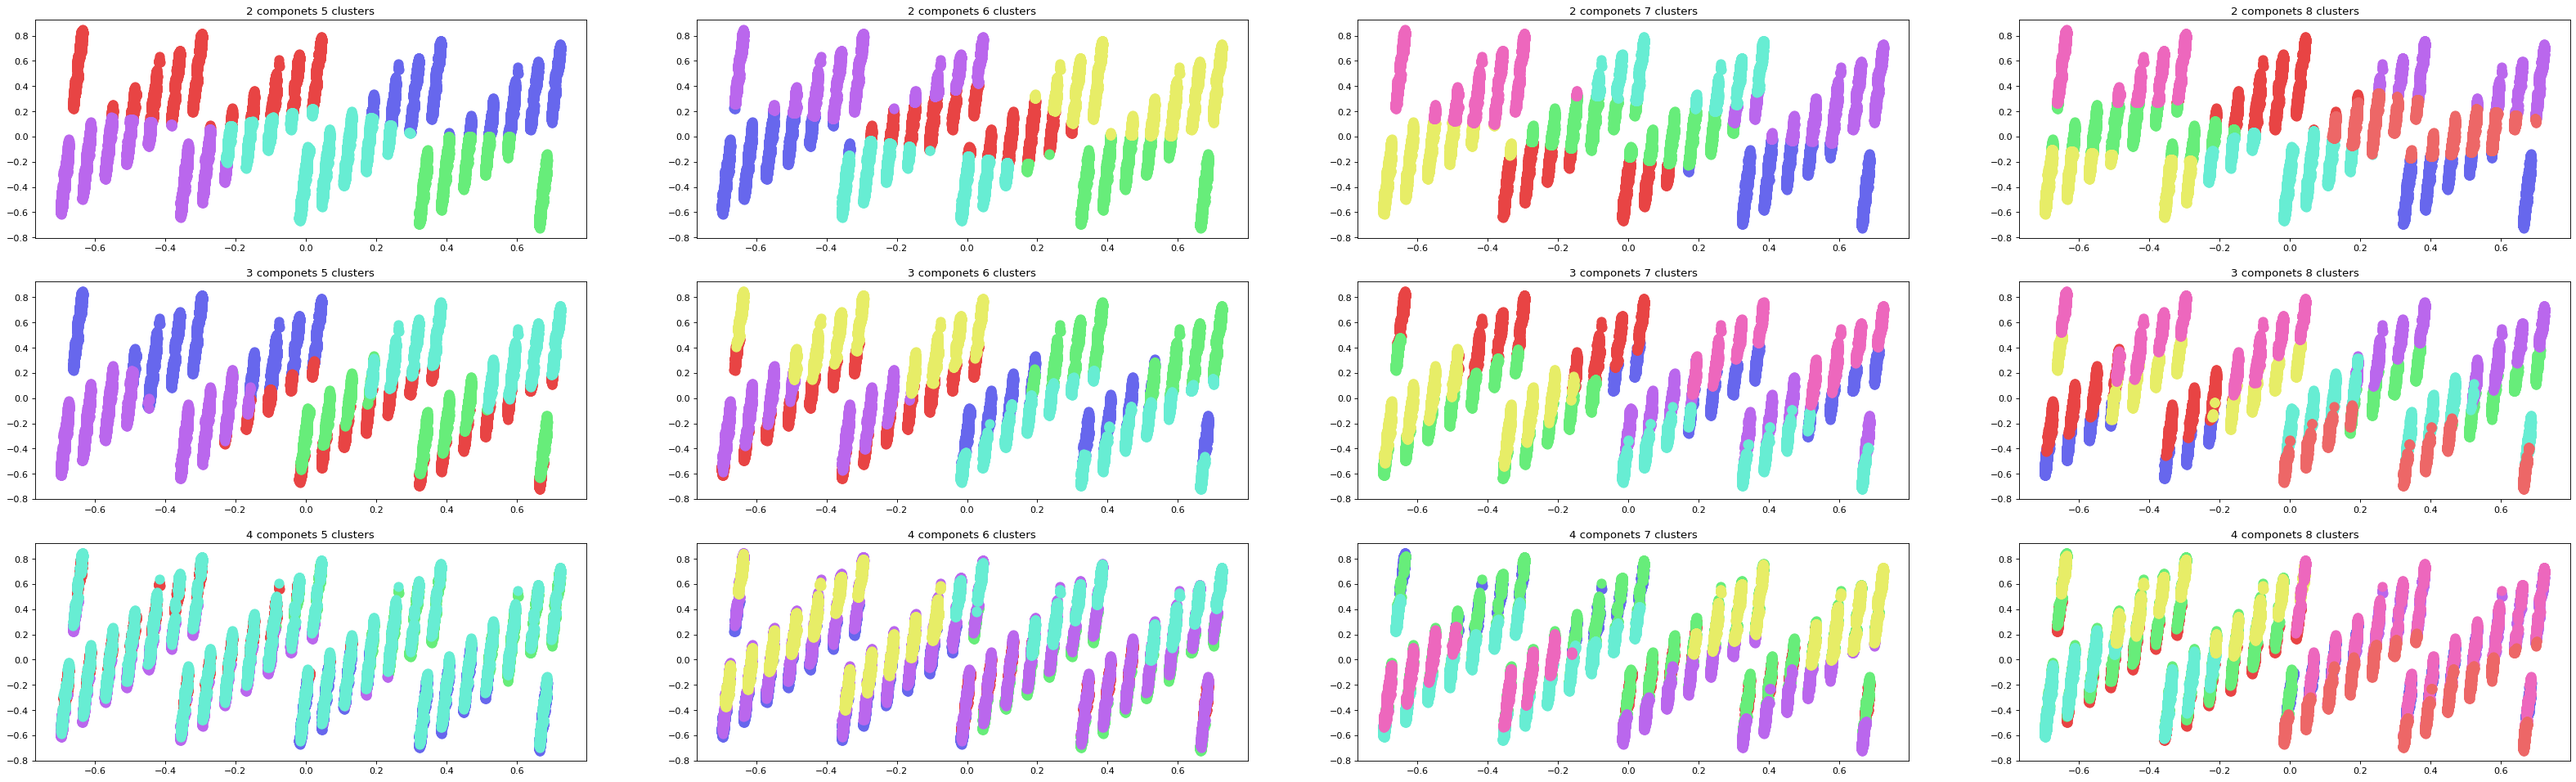

In [ ]:
plt.figure(figsize=(50, 15), dpi=80)
num_components_to_try = [2, 3, 4]
num_clusters_to_try = [5, 6, 7, 8]
for num_components in num_components_to_try:
  for num_clusters in num_clusters_to_try:
      pca = PCA(n_components=num_components)
      pca_components = pca.fit_transform(df_scaled)
      k_means = KMeans(n_clusters=num_clusters, random_state=123).fit_predict(pca_components)
      plt.subplot(len(num_components_to_try), len(num_clusters_to_try), (num_clusters-num_clusters_to_try[0] + 1) + ((num_components-num_components_to_try[0]) * len(num_clusters_to_try)))#this assumes the first element in each array is the smallest and they increment by 1
      plot_k_clusters(k_means, pca_components, 0, 1)
      plt.title("{} componets {} clusters".format(num_components,num_clusters))

plt.show()

The PCA dimension reduction creates odd repetitive non-isotropic patterns which does not support the k-means clustering algorithm. Visual inspection strongly suggests that PCA with k-means clustering is not a good approach.

In [ ]:
for num_pca_components in [2]:
  for k in [5, 6, 7, 8]:
    pca = PCA(n_components=num_pca_components)
    pca_data = pca.fit_transform(df_scaled)
    k_means = KMeans(n_clusters=k, random_state=123).fit_predict(pca_data)
    score = metrics.silhouette_score(pca_data, k_means, metric='euclidean')
    print("{} groups with {} components have score {}".format(k, num_pca_components, score))

5 groups with 2 components have score 0.3870193147470822
6 groups with 2 components have score 0.3860434189505184
7 groups with 2 components have score 0.389909822032103
8 groups with 2 components have score 0.360740846395774


In [ ]:
for num_pca_components in [3]:
  for k in [5, 6, 7, 8]:
    pca = PCA(n_components=num_pca_components)
    pca_data = pca.fit_transform(df_scaled)
    k_means = KMeans(n_clusters=k, random_state=123).fit_predict(pca_data)
    score = metrics.silhouette_score(pca_data, k_means, metric='euclidean')
    print("{} groups with {} components have score {}".format(k, num_pca_components, score))

5 groups with 3 components have score 0.2911112884227956
6 groups with 3 components have score 0.3147243364590058
7 groups with 3 components have score 0.3249054582394393
8 groups with 3 components have score 0.3319110471990494


In [ ]:
for num_pca_components in [4]:
  for k in [5, 6, 7, 8]:
    pca = PCA(n_components=num_pca_components)
    pca_data = pca.fit_transform(df_scaled)
    k_means = KMeans(n_clusters=k, random_state=123).fit_predict(pca_data)
    score = metrics.silhouette_score(pca_data, k_means, metric='euclidean')
    print("{} groups with {} components have score {}".format(k, num_pca_components, score))

5 groups with 4 components have score 0.29442814311636806
6 groups with 4 components have score 0.3022629833467613
7 groups with 4 components have score 0.30271244423069305
8 groups with 4 components have score 0.31884323035897594


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

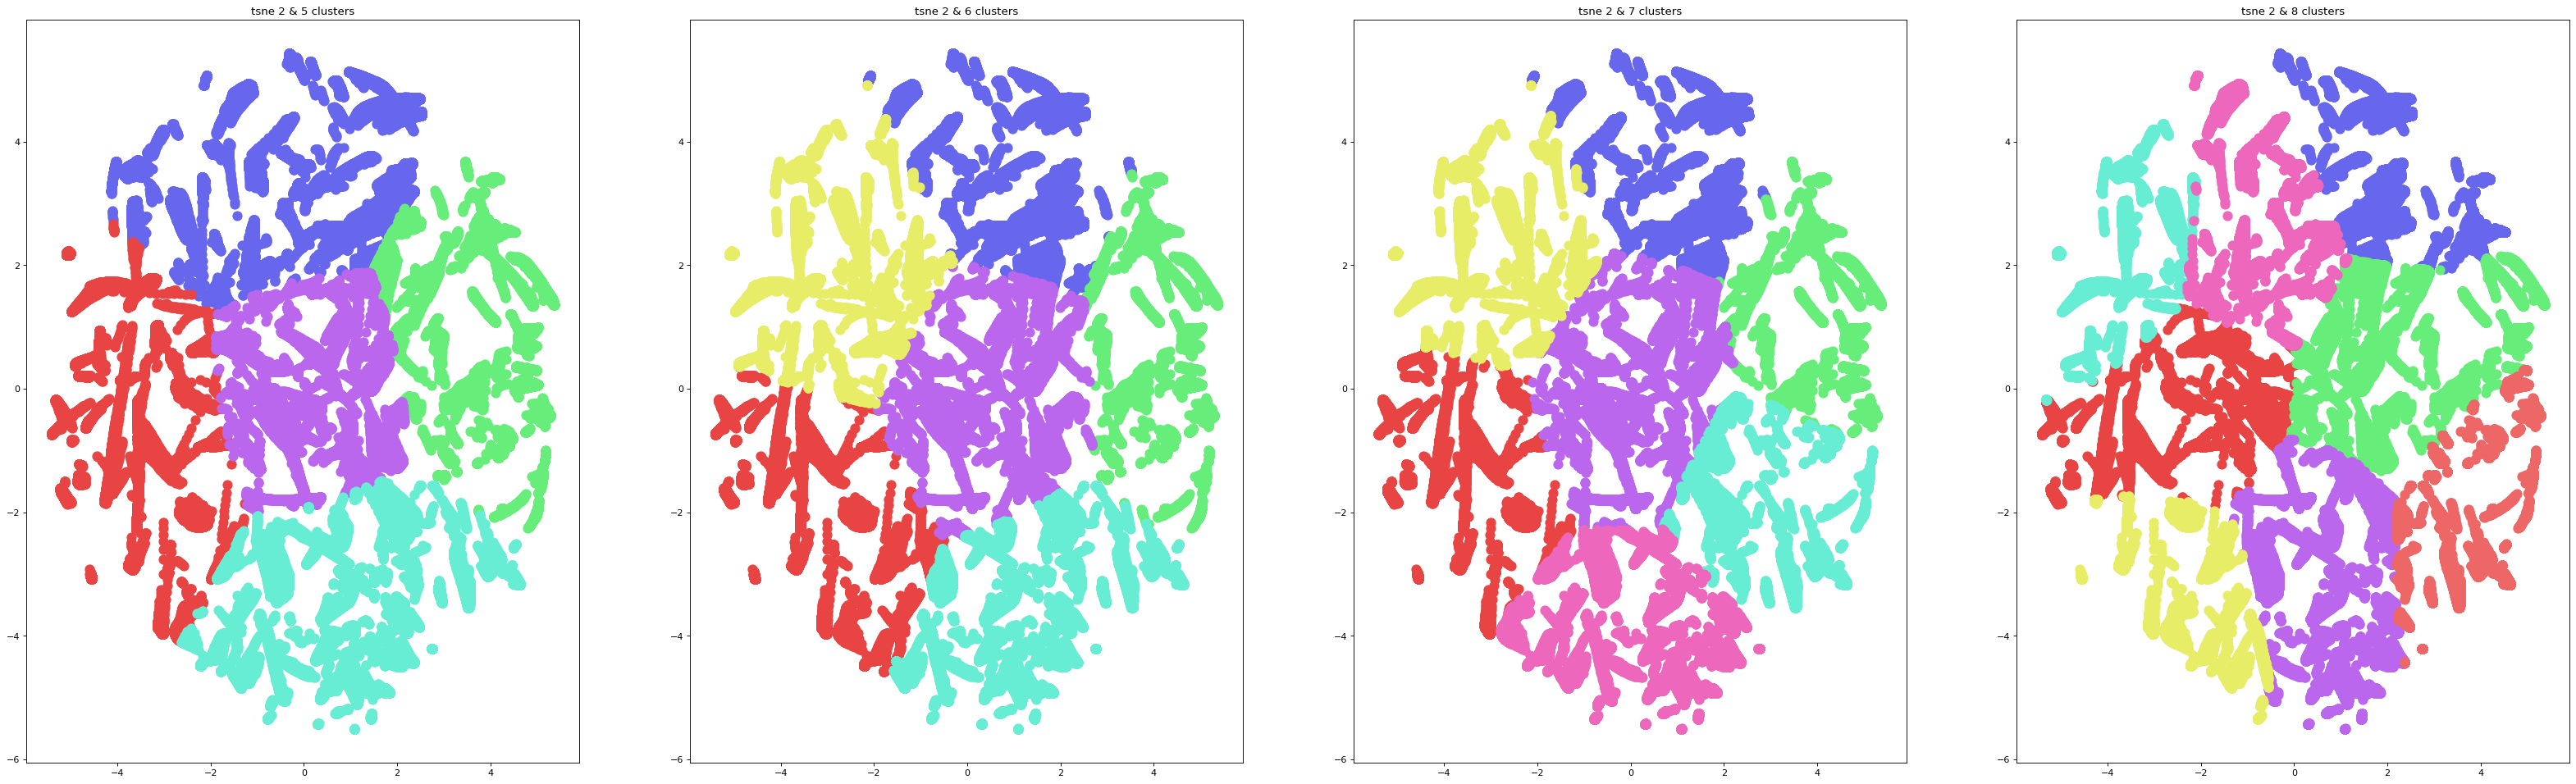

5.0 groups with 2.0 components have score 0.35311105847358704
6.0 groups with 2.0 components have score 0.371591717004776
7.0 groups with 2.0 components have score 0.36764660477638245
8.0 groups with 2.0 components have score 0.3065708577632904


In [ ]:
plt.figure(figsize=(50, 15), dpi=80)
tsne_df = pd.DataFrame()
num_tsne_components = [2]
ks = [5, 6, 7, 8]
for num_tsne_component in num_tsne_components:
  for k in ks:
    tsne = TSNE(n_components=num_tsne_component, verbose=0, perplexity=40, n_iter=300, random_state=123)
    tsne_results = tsne.fit_transform(df_scaled)
    gmm_clusters = GaussianMixture(n_components=k, random_state=123).fit_predict(tsne_results)
    score = metrics.silhouette_score(tsne_results, gmm_clusters, metric='euclidean')
    tsne_df = tsne_df.append({'tsne components':num_tsne_component, 'k':k, 'score':score}, ignore_index=True)
    plt.subplot(len(num_tsne_components), len(ks), (k-ks[0]+1) + ((num_tsne_component - num_tsne_components[0]) * len(ks)))
    plot_k_clusters(gmm_clusters, tsne_results, 0, 1)
    plt.title("tsne {} & {} clusters".format(num_tsne_component, k))

plt.show()
for index, row in tsne_df.iterrows():
  print("{} groups with {} components have score {}".format(row['k'], row['tsne components'], row['score'])) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

KeyboardInterrupt: ignored

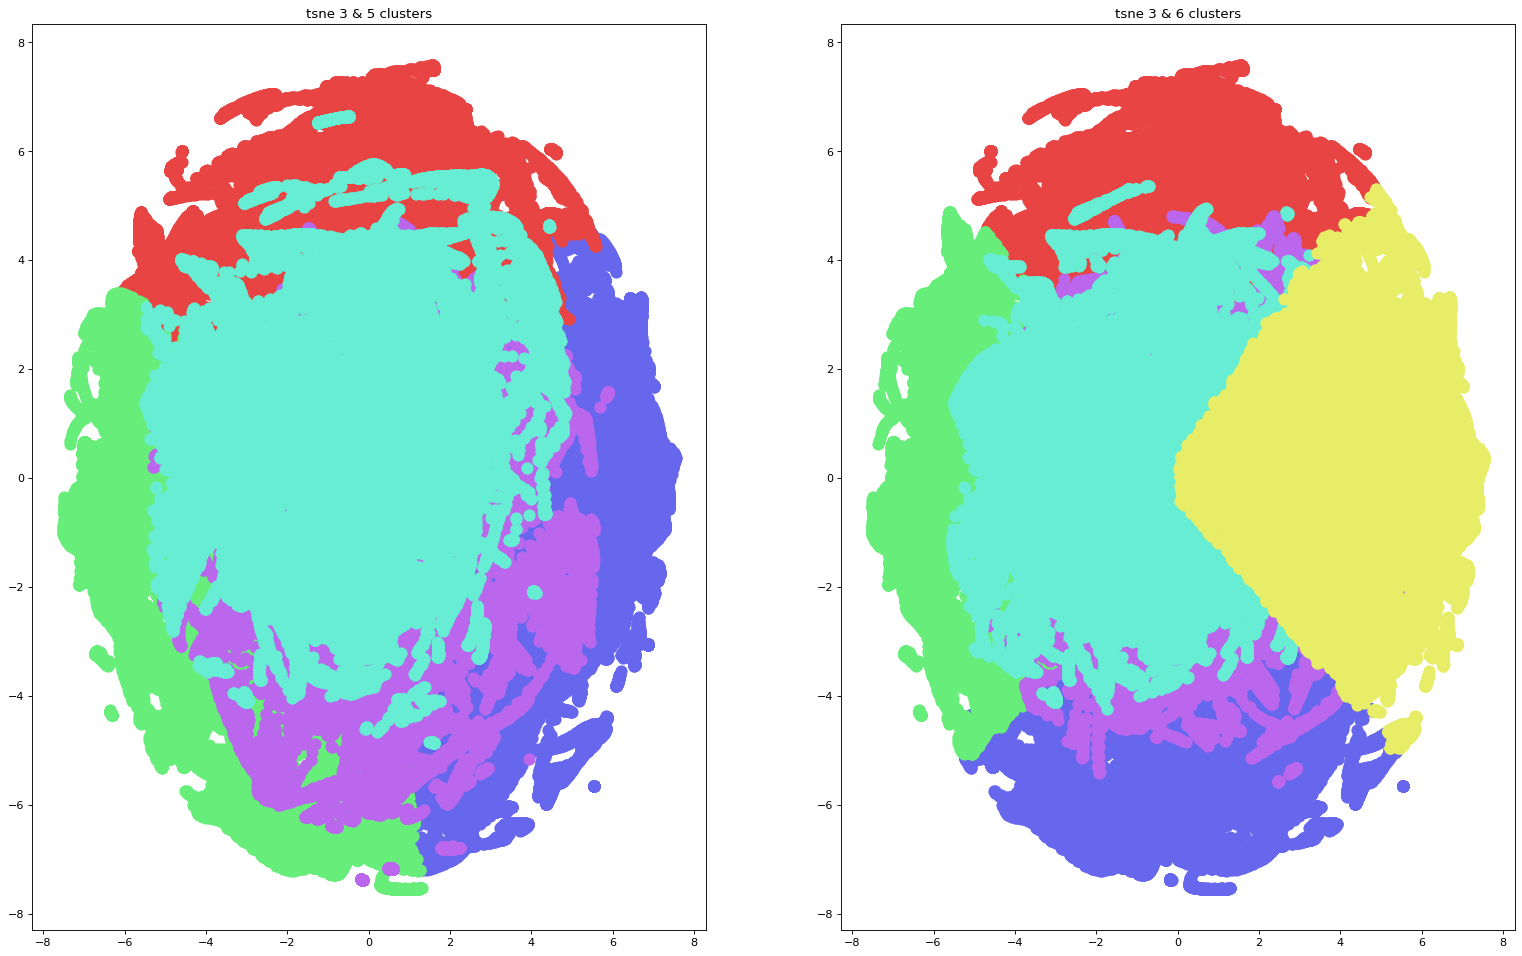

In [ ]:
plt.figure(figsize=(50, 15), dpi=80)
tsne_df = pd.DataFrame()
num_tsne_components = [3]
ks = [5, 6, 7, 8]
for num_tsne_component in num_tsne_components:
  for k in ks:
    tsne = TSNE(n_components=num_tsne_component, verbose=0, perplexity=40, n_iter=300, random_state=123)
    tsne_results = tsne.fit_transform(df_scaled)
    gmm_clusters = GaussianMixture(n_components=k, random_state=123).fit_predict(tsne_results)
    score = metrics.silhouette_score(tsne_results, gmm_clusters, metric='euclidean')
    tsne_df = tsne_df.append({'tsne components':num_tsne_component, 'k':k, 'score':score}, ignore_index=True)
    plt.subplot(len(num_tsne_components), len(ks), (k-ks[0]+1) + ((num_tsne_component - num_tsne_components[0]) * len(ks)))
    plot_k_clusters(gmm_clusters, tsne_results, 0, 1)
    plt.title("tsne {} & {} clusters".format(num_tsne_component, k))

plt.show()
for index, row in tsne_df.iterrows():
  print("{} groups with {} components have score {}".format(row['k'], row['tsne components'], row['score'])) 

The TSNE dimensional reduction creates much more well-behaved-looking data. The GMM clustering creates groups that are much more compact. However, they don't match any patterns that are easy to visibly identify.

The PCA/K-means combination with the best silhouette score has two principal components and seven clusters. The categories found using these parameters are added to the original dataset. 

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)
df['k categories'] = KMeans(n_clusters=7, random_state=123).fit_predict(pca_data)

The TSNE/GMM combination with the best silhouette score has two components and six clusters. This category data is added to the dataset.

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=123)
tsne_results = tsne.fit_transform(df_scaled)
df['gmm categories'] = GaussianMixture(n_components=6, random_state=123).fit_predict(tsne_results)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Now that we have our best categorizations, we can use them to determine which category has the most delays. First, we look at delays on Fridays.

In [ ]:
def plot_friday_delays(df_in, cat_name, title):
  friday_delays = {}
  for i in df_in[cat_name].unique():
    friday_delays[str(i)] = df_in[df_in[cat_name] == i ]['delay_minutes'].sum()
  plt.bar(df_in[cat_name].unique(), friday_delays.values())
  plt.title(title)
  plt.show

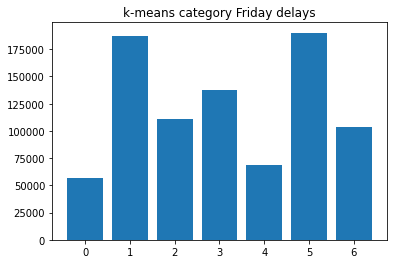

In [ ]:
plot_friday_delays(df, 'k categories', 'k-means category Friday delays')

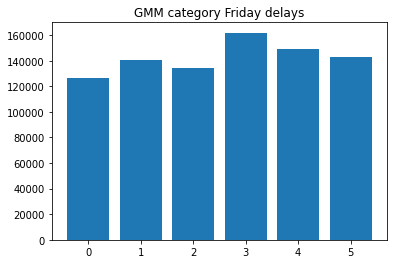

In [ ]:
plot_friday_delays(df, 'gmm categories', 'GMM category Friday delays')

For the categories k-means produces, groups one and five have the most delay on Fridays. For the GMM categories, group three has the most delays. The two approaches clearly came up with significantly different clusters.The GMM clusters have a more consistent amount of delays while the k-means clusters are more thoroughly differentiated.

In [ ]:
def plot_rushhour_delays(df_in, cat_name, title):
  rushhour_delays = {}
  for i in df[cat_name].unique():
    rushhour_delays[str(i)] = df[(df[cat_name] == i) & (df['day_of_week'] < 5) & (((df['scheduled_departure'] > 7 * 60) & (df['scheduled_departure'] < 9 * 60)) | ((df['scheduled_departure'] > 15 * 60) & (df['scheduled_departure'] < 17 * 60)))]['delay_minutes'].sum()
  plt.bar(df_in[cat_name].unique(), rushhour_delays.values())
  plt.title(title)
  plt.show

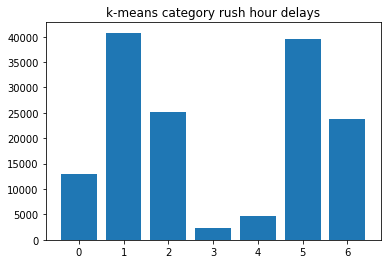

In [ ]:
plot_rushhour_delays(df, 'k categories', 'k-means category rush hour delays')

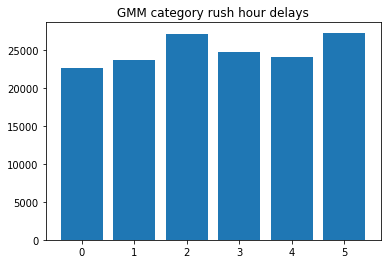

In [ ]:
plot_rushhour_delays(df, 'gmm categories', 'GMM category rush hour delays')

As with the Friday delay data, k-means creates more clearly differentiated groups. Group one has slightly more delay than group five. For GMM, groups two and five now have the most delays.

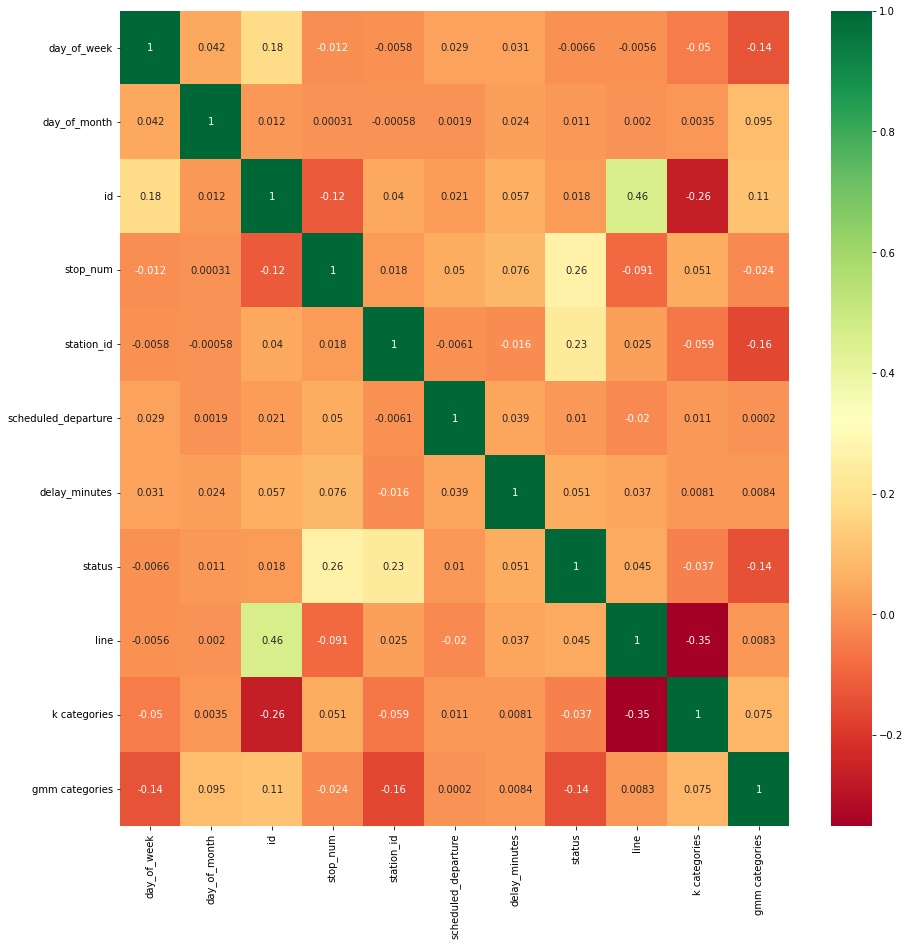

In [ ]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

The k-means categories are highly correlated with the id and the line. It would appear that trains with the same route (id) and on the same line are more similar than those running at the same time or with similar delays.
The GMM categories are not as highly correlated with any specific feature. This indicates that the k-means approach is more explainable.

Neither approach creates groups that are clearly differentiated in visible inspection. PCA creates awkward repetitive patterns in the data. Presumably PCA has such trouble because the data is not linearly separable. After PCA transformation, the data is not isotropic so k-means creates groups that do not match those clearly visible from inspection. T-SNE creates much better behaved lower-dimensional projections. GMM conducted on the t-SNE data creates clusters that are less in conflict with visual inspection. The silhouette scores, however, show a different story. The best silhouette score from PCA and k-means was 0.39 with 2 principal components and 7 clusters. This is superior to the score of 0.37 GMM with t-SNE achieved with 2 components and 6 clusters.

Like the silhouette score, the bar graphs of the delays support k-means as the better approach. The groups are more clearly delineated. Finally, the k-means approach offers more explainability. Despite the way they look, the silhouette score, bar graphs, and heat map show that k-means with PCA is the superior model for this data.
  